In [3]:
import pandas as pd
import json
import os

In [4]:
loadprofile_folder = "./data/loadprofiles/raw"
dfs = {}
for file in os.listdir(loadprofile_folder):
    if file.endswith(".xlsx"):
        type = file.replace(".xlsx", "").replace("BRUI_loadprofiles_", "")
        df = pd.read_excel(os.path.join(loadprofile_folder, file), skiprows=1)
        columns = df.columns
        # rename columns that have "Elektro" in them to "Electro", and "Wärme" to "Heating"
        new_cols = []
        for col in columns:
            if "Elektro" in col:
                new_cols.append("Electro")
            elif "Wärme" in col:
                new_cols.append("Heating")
            else:
                new_cols.append(col)
        df.columns = new_cols
        new_cols[0] = "time"
        df.columns = new_cols
        df["time"] = pd.to_datetime(df["time"])
        
        # all columns expect time * 1000
        for col in df.columns[1:]:
            df[col] = df[col] * 1000
        
        dfs[type] = df

In [5]:
dfs[list(dfs.keys())[0]].head()

,time,Electro,Heating
0,2015-01-01 00:00:00,8.300770,13.756087
1,2015-01-01 01:00:00,8.627364,13.606379
2,2015-01-01 02:00:00,9.277860,13.069518
3,2015-01-01 03:00:00,13.415215,18.524347
4,2015-01-01 04:00:00,13.431999,23.496397


In [6]:
winter_day = "2015-02-14"
summer_day = "2015-07-14"

In [7]:
for type, df in dfs.items():
    df_winter = df[df["time"].dt.date == pd.to_datetime(winter_day).date()]
    df_summer = df[df["time"].dt.date == pd.to_datetime(summer_day).date()]
    # ignore time column
    df_winter = df_winter.drop(columns=["time"])
    df_summer = df_summer.drop(columns=["time"])
    
    winter = {}
    summer = {}
    
    for col in df_winter.columns:
        winter[col] = df_winter[col].to_list()
        summer[col] = df_summer[col].to_list()
    
    with open(f"./data/loadprofiles/winter/{type}.json", "w") as f:
        json.dump(winter, f)
        
    with open(f"./data/loadprofiles/summer/{type}.json", "w") as f:
        json.dump(summer, f)

# Generate PC potential per m2

In [27]:
def pv_potential(direct, diffuse):
    return (direct + diffuse) / 1000

In [28]:
df_weather = pd.read_excel("./data/weather.xlsx")
df_weather.head()

,labels,t,B,D
0,2015-01-01T00:00:00.000,2.7,0,0
1,2015-01-01T01:00:00.000,1.5,0,0
2,2015-01-01T02:00:00.000,0.4,0,0
3,2015-01-01T03:00:00.000,0.4,0,0
4,2015-01-01T04:00:00.000,0.2,0,0


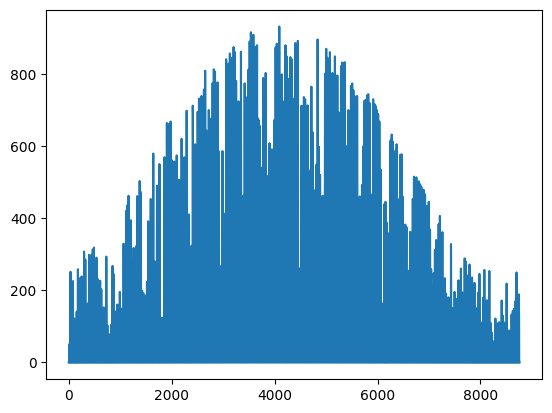

In [29]:
df_weather["total"] = df_weather["B"] + df_weather["D"]
import matplotlib.pyplot as plt
plt.plot(df_weather["total"].to_list())
plt.show()

In [30]:
df_weather["pv_potential"] = df_weather.apply(lambda x: pv_potential(x["B"], x["D"]), axis=1)
df_weather["time"] = pd.to_datetime(df_weather["labels"])
df_weather.head()

,labels,t,B,D,total,pv_potential,time
0,2015-01-01T00:00:00.000,2.7,0,0,0,0.0,2015-01-01 00:00:00
1,2015-01-01T01:00:00.000,1.5,0,0,0,0.0,2015-01-01 01:00:00
2,2015-01-01T02:00:00.000,0.4,0,0,0,0.0,2015-01-01 02:00:00
3,2015-01-01T03:00:00.000,0.4,0,0,0,0.0,2015-01-01 03:00:00
4,2015-01-01T04:00:00.000,0.2,0,0,0,0.0,2015-01-01 04:00:00


In [31]:
dfs.keys()

dict_keys(['COMMERCIAL', 'FARM', 'HIGH_DENSITY_RESIDENTIAL', 'INDUSTRIAL', 'RESIDENTIAL', 'RETAIL', 'TRANSPORT'])

In [32]:
df_industry = dfs["INDUSTRIAL"]
df_industry_winter = df_industry[df_industry["time"].dt.date == pd.to_datetime(winter_day).date()]
df_industry_summer = df_industry[df_industry["time"].dt.date == pd.to_datetime(summer_day).date()]

In [33]:
df_winter = df_weather[df_weather["time"].dt.date == pd.to_datetime(winter_day).date()]
df_summer = df_weather[df_weather["time"].dt.date == pd.to_datetime(summer_day).date()]

winter = {}
summer = {}
winter["pv_potential"] = df_winter["pv_potential"].to_list()
summer["pv_potential"] = df_summer["pv_potential"].to_list()

winter["powerPlantPotential"] = [10000 for _ in range(len(winter["pv_potential"]))]
summer["powerPlantPotential"] = [10000 for _ in range(len(summer["pv_potential"]))]

winter["gasPotential"] = [2000000 for _ in range(len(winter["pv_potential"]))]
summer["gasPotential"] = [2000000 for _ in range(len(summer["pv_potential"]))]

winter["heatingOil"] = [1500000 for _ in range(len(winter["pv_potential"]))]
summer["heatingOil"] = [1500000 for _ in range(len(summer["pv_potential"]))]

winter["districtHeatingPotential"] = [x*0.1 for x in df_industry_winter["Electro"].to_list()]
summer["districtHeatingPotential"] = [x*0.1 for x in df_industry_summer["Electro"].to_list()]

In [34]:
with open(f"./data/loadprofiles/winter/potentials.json", "w") as f:
    json.dump(winter, f)
    
with open(f"./data/loadprofiles/summer/potentials.json", "w") as f:
    json.dump(summer, f)

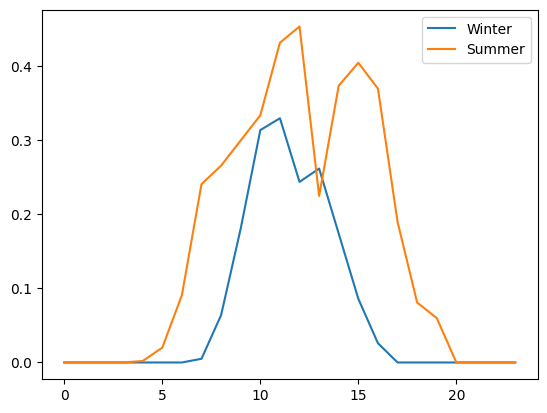

In [35]:
import matplotlib.pyplot as plt

plt.plot(df_winter["pv_potential"].to_list())
plt.plot(df_summer["pv_potential"].to_list())
plt.legend(["Winter", "Summer"])
plt.show()